# [Polynomial & Spline Interpolation with Scikit Learn](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)


## Imports


In [55]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from glob import glob

plt.style.use("ggplot")

## Polynomial & Spline Approximation


### Polynomial Example


In [56]:
def approximate_function(x):
    """Defines a function to approximate.

    Args:
        x (ndarray): This is the list of points that will seed the
                     function.

    Returns:
        ndarray: This is a list of points that are representative of the
                 approximated function.
    """
    return x * np.sin(x)

In [57]:
x_plot = np.linspace(-1, 11, 100)
x_train = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False))
y_train = approximate_function(x_train)

In [58]:
x_train

array([0.2020202 , 0.70707071, 0.80808081, 1.31313131, 1.61616162,
       2.22222222, 2.42424242, 2.62626263, 3.03030303, 3.33333333,
       5.35353535, 5.45454545, 5.55555556, 7.37373737, 7.57575758,
       7.87878788, 8.68686869, 9.29292929, 9.39393939, 9.5959596 ])

In [59]:
y_train

array([ 0.04053512,  0.45931986,  0.58421217,  1.26978173,  1.61449886,
        1.76715568,  1.59367333,  1.29428011,  0.33654557, -0.63522654,
       -4.2903801 , -4.02006959, -3.69500842,  6.5396357 ,  7.28442965,
        7.8763639 ,  5.84402579,  1.22171343,  0.28964971, -1.63464132])

In [60]:
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

In [61]:
x_train.shape

(20,)

In [62]:
X_train.shape

(20, 1)

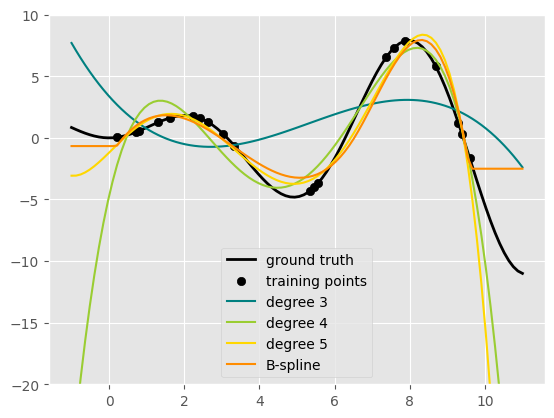

In [63]:
# Plot Function
lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, approximate_function(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_train, y_train, label="training points")

# polynomial features
for degree in [3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")
ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()

In [64]:
y_plot

array([-0.66586151, -0.66586151, -0.66586151, -0.66586151, -0.66586151,
       -0.66586151, -0.66586151, -0.66586151, -0.66586151, -0.66586151,
       -0.62361336, -0.14851759,  0.2693335 ,  0.63226482,  0.94260126,
        1.20266772,  1.4147891 ,  1.58129029,  1.7044962 ,  1.7867317 ,
        1.83032172,  1.83759114,  1.81086485,  1.75246777,  1.66472477,
        1.54996077,  1.41050065,  1.24866933,  1.06679168,  0.86719261,
        0.65219702,  0.42412981,  0.18531586, -0.06191992, -0.31525263,
       -0.57235738, -0.83090892, -1.08854018, -1.34280283, -1.59123921,
       -1.83139167, -2.06080253, -2.27701415, -2.47756885, -2.66000898,
       -2.82187689, -2.9607149 , -3.07406536, -3.1594706 , -3.21447297,
       -3.23661481, -3.22343846, -3.17248625, -3.08130053, -2.94742363,
       -2.7683979 , -2.54176567, -2.26506929, -1.93585109, -1.55165341,
       -1.1100186 , -0.60848899, -0.04479683,  0.57662065,  1.24298952,
        1.9410147 ,  2.6574011 ,  3.37885364,  4.09207723,  4.78

### Periodic Splines Example


/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_26502/2200498788.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


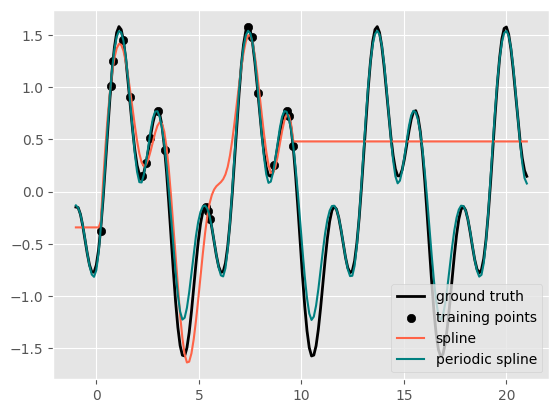

In [65]:
def approximate_periodic_spline(x):
    """Function to be approximated by periodic spline interpolation."""
    return np.sin(x) - 0.7 * np.cos(x * 3)


y_train = approximate_periodic_spline(x_train)

# Extend the test data into the future:
x_plot_ext = np.linspace(-1, 21, 200)
x_plot_ext = x_plot_ext[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(color=["black", "tomato", "teal"])
ax.plot(
    x_plot_ext,
    approximate_periodic_spline(x_plot_ext),
    linewidth=lw,
    label="ground truth",
)
ax.scatter(x_train, y_train, label="training points")

for transformer, label in [
    (SplineTransformer(degree=3, n_knots=10), "spline"),
    (
        SplineTransformer(
            degree=3,
            knots=np.linspace(0, 2 * np.pi, 10)[:, None],
            extrapolation="periodic",
        ),
        "periodic spline",
    ),
]:
    model = make_pipeline(transformer, Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot_ext = model.predict(x_plot_ext)
    ax.plot(x_plot_ext, y_plot_ext, label=label)

ax.legend()
fig.show()

## Neuralink Compression Dataset Design


### Imports


In [66]:
from scipy.io import wavfile
from scipy.signal import detrend, lfilter, butter
import pandas as pd

### Function Definitions


In [67]:
def print_differences_in_array(x_df):
    """This function will print differences between values in a given
       array.

    Args:
        x_df (numpy.ndarray): This is the numpy array of which to print
                              differences.
    """
    count = 0
    duplicate_list = []
    for index in range(0, len(x_df)):
        if index == 0:
            continue
        difference = x_df[index] - x_df[index - 1]
        if difference == 0:
            print(f"difference: {difference}\nindex: {index}")
            duplicate_list.append(index)
            count += 1
    return count, duplicate_list

In [68]:
def estimate_noise_floor(amplitude_array, window_size=10):
    """This function will estimate the noise floor. The amplitude array
    must be at least of length of the window size or a single value.

    Args:
        amplitude_array (numpy.ndarray): Array of amplitudes with which
                                         to derive the noise floor.

        window_size (int, optional): This is the width of the window
                                     used to calculate a rolling median
                                     average.

    Return:
        noise_floor_estimate (np.ndarray): This is the estimate of the
                                           noise floor.
    """
    if len(amplitude_array) == 0:
        raise ValueError("Length of amplitude array must be greater than 0")
    elif len(amplitude_array) == 1:
        noise_floor_estimate = np.array(
            [np.sqrt(np.abs(np.float64(amplitude_array[0])) ** 2)]
        )
        return noise_floor_estimate
    else:
        if len(amplitude_array) < window_size:
            window_size = len(amplitude_array)
        power_of_filtered_data = np.abs(np.float64(amplitude_array) ** 2)

        rolling_median_array = []
        for index in range(0, len(power_of_filtered_data), 1):
            current_median = np.median(
                power_of_filtered_data[index : index + window_size]
            )
            rolling_median_array.append(current_median)

        rolling_median_array = np.array(rolling_median_array)

        noise_floor_estimate = np.sqrt(rolling_median_array)

        return noise_floor_estimate

In [69]:
def identify_potential_initial_spikes(amplitude_array, return_local_maximum=True):
    """This function searches for peak amplitudes that may be initial
    neural spiking activity. This function is extended to filter the
    local maximum or minimum spiking activity. This is used to identify
    second or third spikes as well.

    Args:
        amplitude_array (numpy.ndarray): This contains an array of
                                         amplitudes of neural signal.
        return_local_maximum (bool, optional): This defines the logic of
                                               the returned values. If
                                               True, the values will be
                                               the local maximums of the
                                               amplitude array. When
                                               False,the returned list
                                               will be local minimums.

    Returns:
        list: This is a list of boolean values that indicate whether a
        point is a local maximum with respect to the next and previous
        amplitudes. If return_local_maximum is set to False, then the
        returned list contains information of local minimums instead.
    """
    if len(amplitude_array) < 3:
        if len(amplitude_array) == 0:
            return ValueError("Length of amplitude array must be greater than 0")
        elif len(amplitude_array) == 1:
            return [True]
        else:
            if return_local_maximum:
                if amplitude_array[0] < amplitude_array[1]:
                    return [False, True]
                else:
                    return [True, False]
            else:
                if amplitude_array[0] < amplitude_array[1]:
                    return [True, False]
                else:
                    return [False, True]
    else:
        if return_local_maximum:
            local_maximum_list = []
            for idx, val in enumerate(amplitude_array[0:-1]):
                if idx == 0:
                    if amplitude_array[idx + 1] < val:
                        local_maximum_list.append(True)
                    else:
                        local_maximum_list.append(False)
                    continue
                if (amplitude_array[idx - 1] < val) and (
                    val > amplitude_array[idx + 1]
                ):
                    local_maximum_list.append(True)
                else:
                    local_maximum_list.append(False)
            if amplitude_array[-1] > amplitude_array[-2]:
                local_maximum_list.append(True)
            else:
                local_maximum_list.append(False)
            return local_maximum_list
        else:
            local_minimum_list = []
            for idx, val in enumerate(amplitude_array[0:-1]):
                if idx == 0:
                    if amplitude_array[idx + 1] > val:
                        local_minimum_list.append(True)
                    else:
                        local_minimum_list.append(False)
                    continue
                if (amplitude_array[idx - 1] > val) and (
                    val < amplitude_array[idx + 1]
                ):
                    local_minimum_list.append(True)
                else:
                    local_minimum_list.append(False)
            if amplitude_array[-1] < amplitude_array[-2]:
                local_minimum_list.append(True)
            else:
                local_minimum_list.append(False)
            return local_minimum_list

In [70]:
def detect_neural_spikes(neural_data, single_spike_detection=False):
    """This function detects spikes in real-time.
    It returns an array of spikes at specific times and amplitudes with
    zeroed out noise.

    Args:
        neural_data (array): This is the array of amplitudes for each
                             point of time of the neural data.
        single_spike_detection (bool): This is a boolean flag that
                                       indicates whether a single spike
                                       is to be returned. This will
                                       truncate the neural data to
                                       reflect only these detected
                                       amplitudes that correspond with
                                       the single detected spike.
    Returns:
        (list): This is the array inclusive of amplitudes of spikes at
                each specific point in the initial time array. Non-spike
                points have been replaced with amplitudes of zero value.
    """
    noise_floor_window = 5
    initial_first_point_of_spike_detected = False
    second_point_of_spike_detected = False
    third_point_of_spike_detected = False
    spike_train_time_index_list = []

    for current_time_index, value in enumerate(neural_data):
        # Estimate the noise floor
        if current_time_index < noise_floor_window:
            current_noise_floor_estimate_list = estimate_noise_floor(
                [neural_data[current_time_index]]
            )
        else:
            current_noise_floor_estimate_list = estimate_noise_floor(
                neural_data[
                    current_time_index - noise_floor_window : current_time_index
                ],
                window_size=noise_floor_window,
            )

        current_noise_floor_estimate = current_noise_floor_estimate_list[0]
        current_noise_floor_estimate_inverse = -(current_noise_floor_estimate)

        # Detect Initial First Point
        if initial_first_point_of_spike_detected == False:
            if current_time_index == 0:
                local_maximum_list_of_current_time_index = (
                    identify_potential_initial_spikes(
                        neural_data[current_time_index : current_time_index + 1]
                    )
                )
                is_current_time_index_local_maximum = (
                    local_maximum_list_of_current_time_index[0]
                )
            else:
                local_maximum_list_of_current_time_index = (
                    identify_potential_initial_spikes(
                        neural_data[current_time_index - 1 : current_time_index + 2]
                    )
                )
                is_current_time_index_local_maximum = (
                    local_maximum_list_of_current_time_index[1]
                )

            if is_current_time_index_local_maximum == True:
                # First Point Potentially Identified
                initial_first_point_of_spike_detected = True
                spike_time_index_first_point = current_time_index
        elif (
            second_point_of_spike_detected == False
            and initial_first_point_of_spike_detected == True
        ):
            # Detect Second Point
            local_minimum_list_of_current_time_index = (
                identify_potential_initial_spikes(
                    neural_data[current_time_index - 1 : current_time_index + 2],
                    return_local_maximum=False,
                )
            )
            is_current_time_index_local_minimum = (
                local_minimum_list_of_current_time_index[1]
            )
            if is_current_time_index_local_minimum == True:
                if (
                    neural_data[current_time_index]
                    < current_noise_floor_estimate_inverse
                ):
                    # Second Point Found
                    spike_time_index_list_first_to_second_points = np.arange(
                        start=spike_time_index_first_point,
                        stop=current_time_index,
                        step=1,
                    )
                    spike_time_index_second_point = current_time_index
                    second_point_of_spike_detected = True
                else:
                    initial_first_point_of_spike_detected = False
        elif (
            initial_first_point_of_spike_detected == True
            and second_point_of_spike_detected == True
            and third_point_of_spike_detected == False
        ):
            # Detect Third Point
            local_maximum_list_of_current_time_index = (
                identify_potential_initial_spikes(
                    neural_data[current_time_index - 1 : current_time_index + 2]
                )
            )
            is_current_time_index_local_maximum = (
                local_maximum_list_of_current_time_index[1]
            )
            if is_current_time_index_local_maximum == True:
                if neural_data[current_time_index] > current_noise_floor_estimate:
                    # Third Point Found
                    spike_time_index_list_second_to_third_points = np.arange(
                        spike_time_index_second_point,
                        current_time_index,
                        step=1,
                    )
                    third_point_of_spike_detected = True
                    time_index_of_most_recent_third_spike = current_time_index
                else:
                    initial_first_point_of_spike_detected = True
                    second_point_of_spike_detected = False
                    spike_time_index_first_point = current_time_index
        elif (
            initial_first_point_of_spike_detected == True
            and second_point_of_spike_detected == True
            and third_point_of_spike_detected == True
        ):
            # Detect Fourth Point
            if neural_data[current_time_index] < 0:
                time_index_of_most_recent_fourth_spike_point = current_time_index
                spike_time_index_list_third_to_fourth_points = np.arange(
                    time_index_of_most_recent_third_spike,
                    time_index_of_most_recent_fourth_spike_point
                    + 1,  # include the fourth detected point
                    step=1,
                )
                spike_time_index_list = np.concatenate(
                    [
                        spike_time_index_list_first_to_second_points,
                        spike_time_index_list_second_to_third_points,
                        spike_time_index_list_third_to_fourth_points,
                    ]
                )
                spike_train_time_index_list.append(spike_time_index_list)

                initial_first_point_of_spike_detected = False
                second_point_of_spike_detected = False
                third_point_of_spike_detected = False
                if single_spike_detection == True:
                    break
        else:
            raise ValueError("Error in Spike Detection State")
    if len(spike_time_index_list) > 0:
        return spike_train_time_index_list
    else:
        raise ValueError("No Detected Spikes")

### Detect Neural Spikes


In [71]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")
current_data_file = data_file_l[0]
current_data_file = "../../data/0052503c-2849-4f41-ab51-db382103690c.wav"
current_data_file

'../../data/0052503c-2849-4f41-ab51-db382103690c.wav'

In [72]:
sample_rate, raw_neural_data = wavfile.read(current_data_file)
time_array_length = len(raw_neural_data) / sample_rate
time_array = np.arange(start=0, stop=time_array_length, step=(1 / sample_rate))

In [73]:
# Detrend
detrended_neural_data = np.int16(detrend(raw_neural_data))

In [74]:
nyq = sample_rate // 2
low_cutoff_freq = 500
high_cutoff_freq = 5000
low = low_cutoff_freq / nyq
high = high_cutoff_freq / nyq
order = 4
numerator, denominator = butter(order, [low, high], btype="band")

filtered_data_bandpass = np.int16(
    lfilter(numerator, denominator, detrended_neural_data)
)

In [75]:
spike_train_time_index_list = detect_neural_spikes(filtered_data_bandpass)

##### Create the Pandas Dataframe


In [76]:
df = pd.DataFrame(filtered_data_bandpass, columns=["Amplitude"])

In [77]:
# df.set_index(time_array, inplace=True)
# df.index.name = "Time [S]"
# df.head()

##### Plot the Data


<Axes: title={'center': 'Detected Spike Number: 1'}>

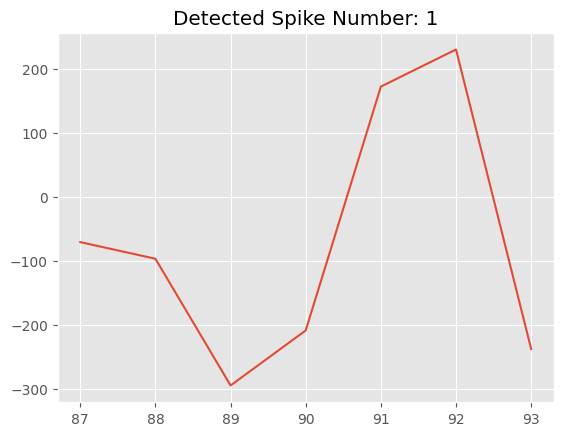

In [78]:
# CURRENT_SPIKE = len(spike_train_time_index_list) - 1
CURRENT_SPIKE = 1
plt.title(f"Detected Spike Number: {CURRENT_SPIKE}")
df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].plot()

In [79]:
CURRENT_SPIKE = 1

In [80]:
df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]]

87    -71
88    -97
89   -295
90   -209
91    172
92    230
93   -238
Name: Amplitude, dtype: int16

In [81]:
# Test to Detect Duplicates
count = 0
duplicate_list = []
for index in range(0, len(spike_train_time_index_list)):
    current_count, current_duplicate_list = print_differences_in_array(
        spike_train_time_index_list[index]
    )
    count += current_count
    duplicate_list.append(current_duplicate_list)
duplicate_list = np.array(duplicate_list)
if duplicate_list.shape[1] != 0:
    # Duplicates are present; List is non-empty ∴ Resize to 1-dim array
    duplicate_list.resize(duplicate_list.shape[0])

In [82]:
duplicate_list.shape[1]

0

In [83]:
var = duplicate_list[0]

In [84]:
var

array([], dtype=float64)

In [85]:
if var.size > 0:
    print("TRUE")

In [86]:
if duplicate_list.size > 0:
    CURRENT_SPIKE = 0
    spike_train_time_index_list[0][duplicate_list[0] - 1]
    spike_train_time_index_list[0][11:13]
else:
    print(
        f"There are no detected duplicates; \nduplicate_list.size: {duplicate_list.size}"
    )

There are no detected duplicates; 
duplicate_list.size: 0


## Neuralink Compression Methods


### Fit a polynomial to the data and make a prediction using a ridge regression & pipeline


In [212]:
x_train = df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values

In [213]:
y_train = df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].values

In [214]:
X_train = x_train[:, np.newaxis]

In [215]:
X_train.shape

(7, 1)

In [216]:
y_train

array([ -71,  -97, -295, -209,  172,  230, -238], dtype=int16)

In [217]:
degree = 3

In [218]:
model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
# model = make_pipeline(PolynomialFeatures(degree))

In [219]:
type(model)

sklearn.pipeline.Pipeline

In [220]:
model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge(alpha=0.001))])

In [221]:
x_train

array([87, 88, 89, 90, 91, 92, 93])

In [222]:
X_train

array([[87],
       [88],
       [89],
       [90],
       [91],
       [92],
       [93]])

In [223]:
y_plot = model.predict(X_train)

In [224]:
y_plot

array([-161.53536967, -117.14055392,  -81.32334796,  -54.35024324,
        -36.48773118,  -28.00230322,  -29.16045081])

In [225]:
x_plot = np.linspace(
    X_train.min(),
    X_train.max(),
    # df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values.min(),
    # df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values.max(),
    len(y_plot),
)

In [226]:
df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values.max(),

(93,)

In [227]:
X_train

array([[87],
       [88],
       [89],
       [90],
       [91],
       [92],
       [93]])

In [228]:
len(x_plot) == len(y_plot)

True

In [229]:
y_plot.shape

(7,)

In [230]:
x_plot

array([87., 88., 89., 90., 91., 92., 93.])

In [231]:
df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values

array([87, 88, 89, 90, 91, 92, 93])

In [232]:
len(df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]])

7

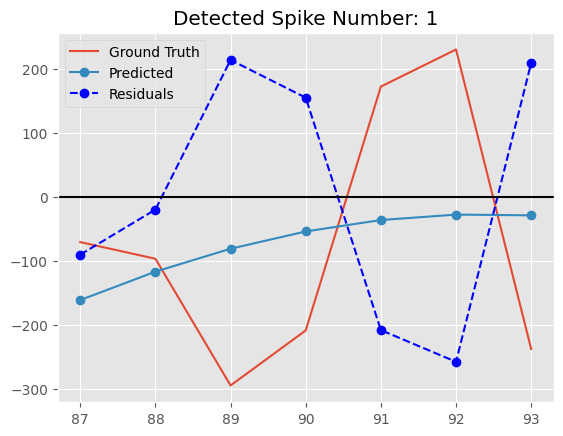

In [233]:
# CURRENT_SPIKE = len(spike_train_time_index_list) - 1
CURRENT_SPIKE = 1
plt.title(f"Detected Spike Number: {CURRENT_SPIKE}")
df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].plot(
    label="Ground Truth"
)

plt.plot(x_plot, y_plot, "-o", label="Predicted")
plt.plot(
    x_plot,
    y_plot - df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].values,
    "--bo",
    label="Residuals",
)
plt.axhline(y=0, color="black")
plt.grid(True)
plt.legend()

### Attempting to create zero residuals using a Spline


#### Example


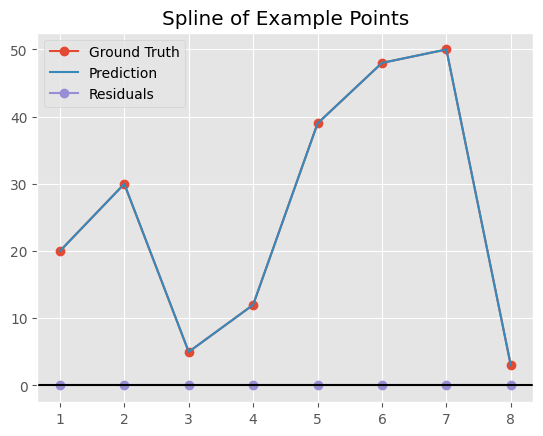

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Dataset
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([20, 30, 5, 12, 39, 48, 50, 3])

X_Y_Spline = make_interp_spline(x, y)
# scipy.interpolate.m

X_ = np.linspace(x.min(), x.max(), len(x))
Y_ = X_Y_Spline(X_)

plt.plot(x, y, "-o", label="Ground Truth")
plt.plot(X_, Y_, "-", label="Prediction")
plt.plot(x, y - Y_, "-o", label="Residuals")
plt.axhline(y=0, color="black")
plt.title("Spline of Example Points")
plt.legend()
plt.show()

#### Applying the Example


In [109]:
x_df = df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].values

In [110]:
x_df

array([ -71,  -97, -295, -209,  172,  230, -238], dtype=int16)

In [111]:
type(x_df)

numpy.ndarray

In [112]:
print_differences_in_array(x_df)

(0, [])

In [113]:
df.iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values

array([87, 88, 89, 90, 91, 92, 93])

<Axes: >

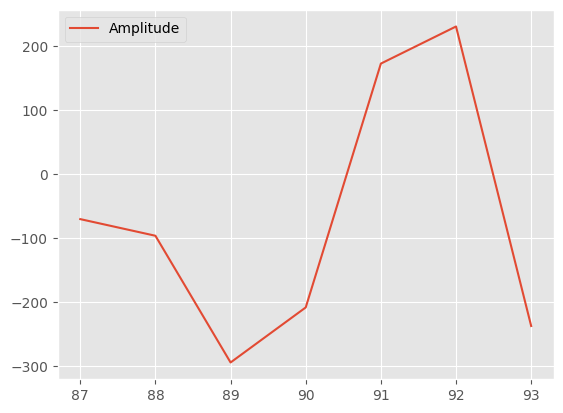

In [114]:
df.iloc[spike_train_time_index_list[CURRENT_SPIKE]].plot()

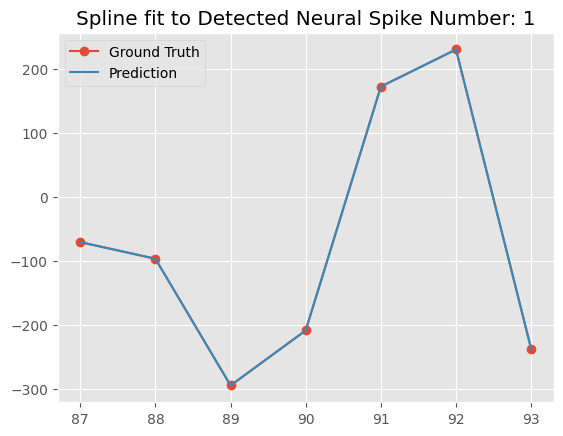

Spline Degree: 0
# of Knots: 8
# of Coefficients: 7
# of Amplitudes in Spike: 7

 Knots: [87. 88. 89. 90. 91. 92. 93. 93.]

 Coefficients: [ -71.  -97. -295. -209.  172.  230. -238.]


In [193]:
# Dataset
CURRENT_SPIKE = 1

x_df = df.iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values
y_df = df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].values

X_Y_Spline = make_interp_spline(x_df, y_df, k=0)
Y_ = X_Y_Spline(x_df)

plt.plot(x_df, y_df, "-o", label="Ground Truth")
plt.plot(x_df, Y_, label="Prediction")
plt.title(f"Spline fit to Detected Neural Spike Number: {CURRENT_SPIKE}")
plt.legend()
plt.show()

print(f"Spline Degree: {X_Y_Spline.k}")
print(f"# of Knots: {len(X_Y_Spline.t)}")
print(f"# of Coefficients: {len(X_Y_Spline.c)}")
print(f"# of Amplitudes in Spike: {len(y_df)}")

print(f"\n Knots: {X_Y_Spline.t}")

print(f"\n Coefficients: {X_Y_Spline.c}")

if len(X_Y_Spline.c) < len(y_df):
    print("Number of coefficients are less than the number of amplitudes")

In [126]:
# X Values that created the spline:
x_df

array([87, 88, 89, 90, 91, 92, 93])

In [127]:
# Y Values that created the spline:
y_df

array([ -71,  -97, -295, -209,  172,  230, -238], dtype=int16)

In [128]:
# Spline Coefficients
X_Y_Spline.c

array([ -71.        ,   85.19047619, -375.38095238, -287.76190476,
        429.95238095,  261.52380952, -238.        ])

In [129]:
# Spline Knots
X_Y_Spline.t

array([87., 87., 87., 87., 89., 90., 91., 93., 93., 93., 93.])

In [130]:
# Spline Degree
X_Y_Spline.k

3

In [ ]:
# Seeing if the axioms are true to reality

#### Testing a Hypothesis of recreating a spline as a means of compression.


In [132]:
"""
    Axioms:
    The degree of the spline is implicit.
    The knots of the spline are equidistant. 
    The initial and final values are known values of the array of spike
        amplitudes. (Costs 2 values).
    The sample rate is known. (Costs 1 value). Each amplitude is also
        equidistant by the sample rate from the known amplitude. 
    The number of coefficients that create the spline are less than the
        number of amplitudes present in the array of spike amplitudes.

    ∴

    Hypothesis:
    The Spline knots can be inferred information from the above axioms, 
        and there will be less information needed to recreate the spline
        than the number of points in the array of spike amplitudes, and 
        thus there is compression.
"""

'\n    Axioms:\n    The degree of the spline is implicit.\n    The knots of the spline are equidistant. \n    The initial and final values are known values of the array of spike\n        amplitudes. (Costs 2 values).\n    The sample rate is known. (Costs 1 value). Each amplitude is also\n        equidistant by the sample rate from the known amplitude. \n    The number of coefficients that create the spline are less than the\n        number of amplitudes present in the array of spike amplitudes.\n\n    ∴\n\n    Hypothesis:\n    The Spline knots can be inferred information from the above axioms, \n        and there will be less information needed to recreate the spline\n        than the number of points in the array of spike amplitudes, and \n        thus there is compression.\n'

##### Example of the Hypothesis on a sample dataset


In [135]:
from scipy.interpolate import BSpline

In [136]:
k = 2
t = [0, 1, 2, 3, 4, 5, 6]
c = [-1, 2, 0, -1]
spl = BSpline(t, c, k)
spl

In [140]:
spl(t)

array([-15.5,  -5. ,   0.5,   1. ,  -0.5,  -1. ,  -0.5])

### Fitting a Polynomial to the data using the numpy library


#### Imports and data frame creation


In [329]:
import numpy as np

In [235]:
x_df

array([87, 88, 89, 90, 91, 92, 93])

In [236]:
y_df

array([ -71,  -97, -295, -209,  172,  230, -238], dtype=int16)

#### Fitting the polynomial


##### Example


In [271]:
x = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0])
z = np.polyfit(x, y, 3)
z

array([ 0.08703704, -0.81349206,  1.69312169, -0.03968254])

In [284]:
z[0] * x[0] ** 3 + z[1] * x[0] ** 2 + z[2] * x[0] ** 1 + z[3]

-0.039682539682538945

In [272]:
p = np.poly1d(z)

In [285]:
y_p = p(x)

In [286]:
y_p[0]

-0.039682539682538945

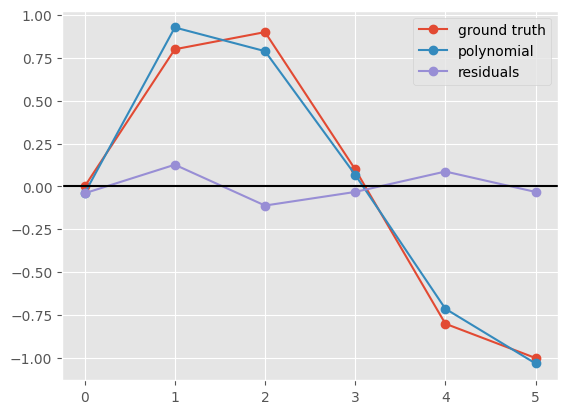

In [287]:
plt.plot(x, y, "-o", label="ground truth")
plt.plot(x, p(x), "-o", label="polynomial")
plt.plot(x, p(x) - y, "-o", label="residuals")
plt.axhline(y=0, color="black")
plt.legend()
plt.show()

##### Applying the example


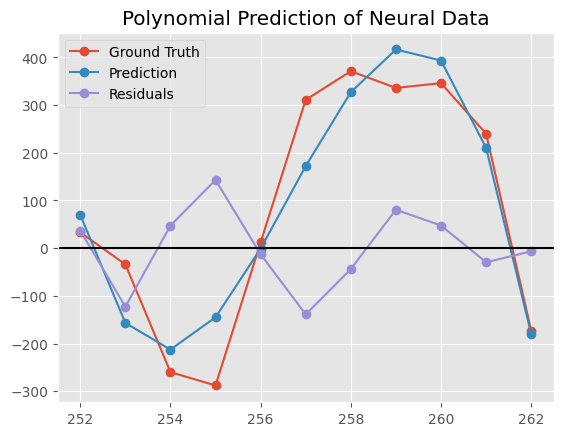

In [324]:
CURRENT_SPIKE = 7
x_df = df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values
y_df = df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].values

coefficients = np.polyfit(x_df, y_df, deg=3)
polynomial = np.poly1d(coefficients)

y_pred = polynomial(x_df)
residuals = y_pred - y_df

plt.plot(x_df, y_df, "-o", label="Ground Truth")
plt.plot(x_df, y_pred, "-o", label="Prediction")
plt.plot(x_df, residuals, "-o", label="Residuals")
plt.axhline(y=0, color="black")
plt.title("Polynomial Prediction of Neural Data")
plt.legend()
plt.show()

if 0 in residuals:
    print("Zero Residual Identified")

In [328]:
for spike in range(0, len(spike_train_time_index_list)):
    """Searching for zero-valued residuals"""
    CURRENT_SPIKE = spike
    x_df = df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].index.values
    y_df = df["Amplitude"].iloc[spike_train_time_index_list[CURRENT_SPIKE]].values

    coefficients = np.polyfit(x_df, y_df, deg=3)
    polynomial = np.poly1d(coefficients)
    y_pred = polynomial(x_df)
    residuals = y_pred - y_df

    if 0 in residuals:
        print(f"Zero Residual Identified.\nCurrent Spike: {CURRENT_SPIKE}")
        print(f"Residuals: {residuals}")

Zero Residual Identified.
Current Spike: 1016
Residuals: [  37.6875 -103.6875   59.875    68.      -69.9375    0.       11.1875]
Zero Residual Identified.
Current Spike: 1473
Residuals: [ 18.375 -59.625  38.     24.375 -36.      0.      2.5  ]
Zero Residual Identified.
Current Spike: 1563
Residuals: [  35.  -108.5   91.5   46.5  -90.5   36.5    0. ]
Zero Residual Identified.
Current Spike: 1618
Residuals: [  38.  -119.5   77.5   57.5  -71.5    0.    10. ]
Zero Residual Identified.
Current Spike: 1831
Residuals: [ 13.5   -41.5    33.875  15.    -31.75   10.625   0.   ]
Zero Residual Identified.
Current Spike: 2256
Residuals: [ 29.5  -60.75 -15.    27.75  37.     0.   -44.75  -6.75  12.5 ]
Zero Residual Identified.
Current Spike: 2261
Residuals: [  26.  -103.5   64.5   40.   -67.     1.     0. ]
Zero Residual Identified.
Current Spike: 2272
Residuals: [ -68.75   26.    164.75    0.   -189.25  -67.     71.75   49.     57.5
  -63.25]
Zero Residual Identified.
Current Spike: 2275
Residuals:

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_26502/2965994131.py:7: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_df, y_df, deg=3)
/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_26502/2965994131.py:7: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_df, y_df, deg=3)
/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_26502/2965994131.py:7: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_df, y_df, deg=3)
/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_26502/2965994131.py:7: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_df, y_df, deg=3)
/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_26502/2965994131.py:7: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_df, y_df, deg=3)
/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_26502/2965994131.py:7: RankWarning: Polyfit may be poorly con